# Chromatix 101

Here we describe the basic ideas behind chromatix by building a simulation of a simple 4f system.

In [1]:
import jax.numpy as jnp
from jax import random

from chromatix import Field, OpticalSystem, Microscope
import chromatix.functional as cx
import chromatix.elements as ce
from chromatix.ops.fft import optical_fft
from chromatix.ops.noise import shot_noise

from skimage.data import astronaut
import matplotlib.pyplot as plt

from typing import Optional

key = random.PRNGKey(42)
%config InlineBackend.figure_format='retina'

## Lightfields


Chromatix's core datatype is the `Field`. The `Field` is a container representing the lightfield, consisting of:

1. The lightfield itself, with shape `[batch x height x width x wavelength]`. When a field gets transformed by an optical element such as a lens or an SLM each batch gets transformed independently. You can use the batch axis for example to work on multiple images at once, or have it act as the depth dimension (the optical axis) when you're working with 3D lightfields.
2. The coordinates of the lightfield, in practice given by the spacing between two grid points. We work with centered grids, meaning we consider `x = y = 0` as the optical axis, and that the field points are defined between `[-N//2, N//2]`.
3. The spectrum and the corresponding spectral density. Currently we only support single-wavelength, but multi-wavelength should hit master soon!

Let's have a look at how this works in practice. As we're simulating a 2f system, our source will be a point source at a distance f from the first lens. In this case, the field caused by the point source can actually be calculated analytically. In chromatix we call this the `objective_point_source`:

In [2]:
# We first create an empty field. 
field = cx.empty_field(shape=(512, 512), dx=1.0, spectrum=0.532, spectral_density=1.0)

# And then turn it into the field generated by the point source afterb the lens.
field = cx.objective_point_source(field, z=0.0, f=10.0, n=1.0, NA=0.8)

You can access standard properties of lightfields such as their intensity or power:

In [3]:
# Getting the intensity
print(field.intensity.shape) # intensity at each point in the field

# Field power
print(field.power) # returns power in each batch and wavelength

(1, 512, 512, 1)
[[[[1.0000002]]]]


We often want to sample or calculate some property at the same grid as the field, for example when applying a phase mask. You can easily acces these grids: 


In [4]:
# Standard x-y grid
print(field.grid.shape) # returns a grid of shape [2, 1, height, width, 1]

# L2 squared grid
print(field.l2_sq_grid.shape) # returns x^2 + y^2 of shape [1, height, width, 1]

(2, 1, 512, 512, 1)
(1, 512, 512, 1)


Additionally, `Fields` have all their standard mathematical operations implemented:

In [5]:
# We can simply add fields:
print((field + field).shape)

# Applying some phase change.
phase = jnp.pi / 10 * field.l2_grid 
print((field * jnp.exp(1j * phase)).shape)

(1, 512, 512, 1)
(1, 512, 512, 1)


## Optical elements as parametrized transformations

The core idea behind Chromatix is that optical elements perform *parametrized transformations* on lightfields. Code-wise this means that optical elements take in a `Field` as a first argument and an additional number of parameters and return a `Field`. 

As we're simulating a 4f system, let's take a 2f lens as example:

In [6]:
def ff_lens(field: Field, f: float, n: float, NA: Optional[float] = None, inverse: bool = False, loop_axis: Optional[int] = None) -> Field:
    # Pupil
    if NA is not None:
        D = 2 * f * NA / n  # Expression for NA yields width of pupil
        field = cx.circular_pupil(field, D)

    return optical_fft(field, f, n, loop_axis, inverse)

We can use our lens with the `field` we created in the previous section:

In [7]:
# Thin lens with focal distance 10, refractive index 1.33 and NA 0.8
field = ff_lens(field, f=10.0, n=1.0, NA=0.8)

All optical elements under `chromatix.functional` follow this approach. We've implemented several different lightfield sources (point source, plane wave, ...), lenses (thin lens, ff lens, ...), and diffraction propagators (transfer method, exact method, ...) and more. See our API for the full list.

An important remark is that we require the functions to be *functional* (as implied by the name :-)). This means that the output field may only depend on the inputs to each function; there can be no hidden internal state. A functional approach is required for Jax (and differentiable programming in general), and makes messing around in Jupyter notebooks a lot easier. 


!!! tip
    This also makes it straightforward to implement new elements: they just need to be function whose first input is a `Field` and they must return a `Field` - what you do inbetween is up to you. 


## Elements and Optical Systems

The functional interface quickly becomes cumbersome when you're building larger models with several elements you want to optimize. To deal with this we've build a more classical deep-learning style `chromatix.elements` API where each optical element is a [Flax](https://flax.readthedocs.io/en/latest/) `Module`. We highly recommend reading the [Flax tutorial](https://flax.readthedocs.io/en/latest/guides/index_flax_fundamentals.html) before reading this section.

As an example, let's use the 2f lens from the previous section again:

In [8]:
model = ce.FFLens(f=10.0, n=1.0, NA=0.8)
params = model.init(key, field) # initializing parameters of model
field = model.apply(params, field)
print(params) # empty dict

FrozenDict({})


When we print the `params` we that it's an empty dictionary, meaning that we're not optimizing any of the parameters of `ThinLens`. We use simple pattern to decide which parameters are optimizable: 

**To make a parameter trainable, it should be a function with an rng key as input and the initial value as output.**

A few examples:

In [9]:
# Refractive index is trainable, fixed init 
# TODO: this init will change soon and is currently bugged.
#model = ce.FFLens(f=10.0, n=lambda _: 1.0, NA=0.8) 
#params = model.init(key, field)
#print(params)

A model consisting of just a thin lens isn't very interesting. To chain multiple elements together into a single optical system, you can use `OpticalSystem`:


In [10]:
model = OpticalSystem([ce.ObjectivePointSource(shape=(512, 512), 
                                               dx=1.0, 
                                               spectrum=0.532, 
                                               spectral_density=1.0,
                                               f=10.0, 
                                               n=1.0, 
                                               NA=0.8), 
                       ce.FFLens(f=10.0, 
                                 n=1.0, 
                                 NA=0.8)])

params=model.init(key, z=0.0) # Inputs at runtime are distance z of point source.
out_field = model.apply(params, z=0.0) # Field after 4f system.

The intensity of the `out_field` is the intensity due to a point source - the PSF!

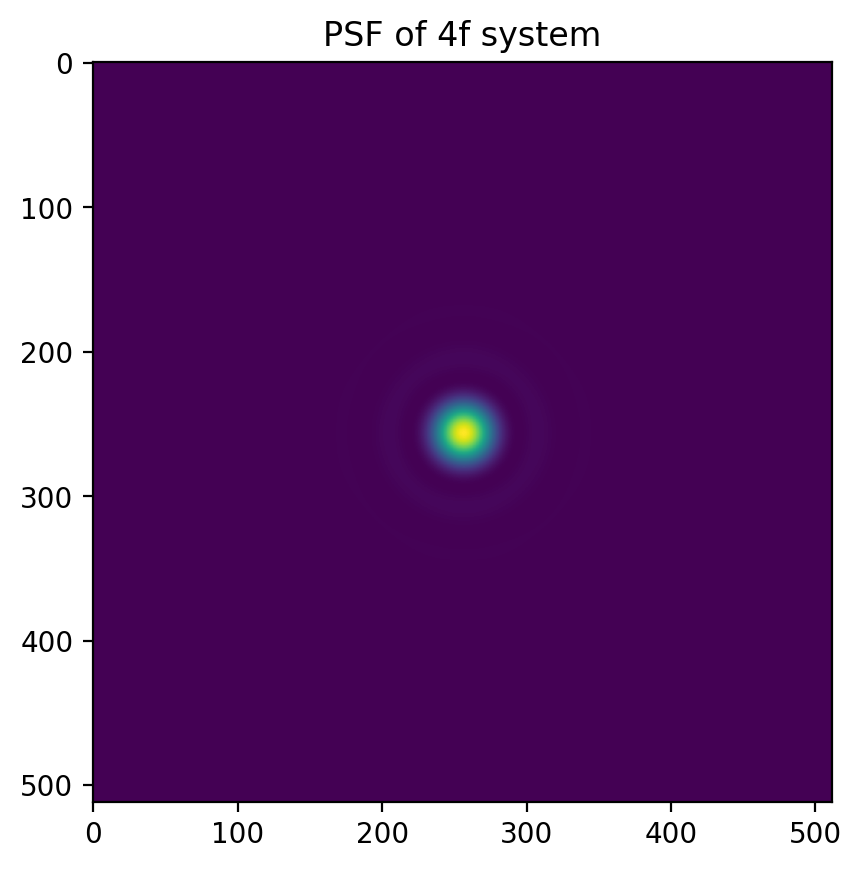

In [11]:
plt.imshow(out_field.intensity.squeeze())
plt.title("PSF of 4f system")
plt.show()

## Microscope


Most systems are approximately translation invariant and can be characterized by a point spread function. For these systems the `Microscope` is useful, combining the `OpticalSystem`, a noise model for the sensor and a so-called `reduce_fn`. The `reduce_fn` defines how the batch is processed before the noise is added. This is useful when imaging 3D fields: we want to first add all the components of the field along the optical axis, and only then add the sensor noise. We ignore these arguments here to show how to image, but you can see there uses in the examples.


In [12]:
system = [ce.ObjectivePointSource(shape=(512, 512), 
                                               dx=1.0, 
                                               spectrum=0.532, 
                                               spectral_density=1.0,
                                               f=10.0, 
                                               n=1.0, 
                                               NA=0.8), 
                       ce.FFLens(f=10.0, 
                                 n=1.0, 
                                 NA=0.8)]

model = Microscope(system, 
                  noise_fn=None,
                  reduce_fn=None)

params = model.init({"params": key, "noise": key}, z=0.0, data=jnp.ones((1, 512, 512, 1))) # note the extra key for the noise and the fake data

The `PSFImager` calculates the PSF, and performs a convolution with the supplied data to generate the image made by this system. Let's image the famous astronaut:

In [13]:
data = astronaut()[..., 0][None, ..., None]
image = model.apply(params, z=0, data=data)

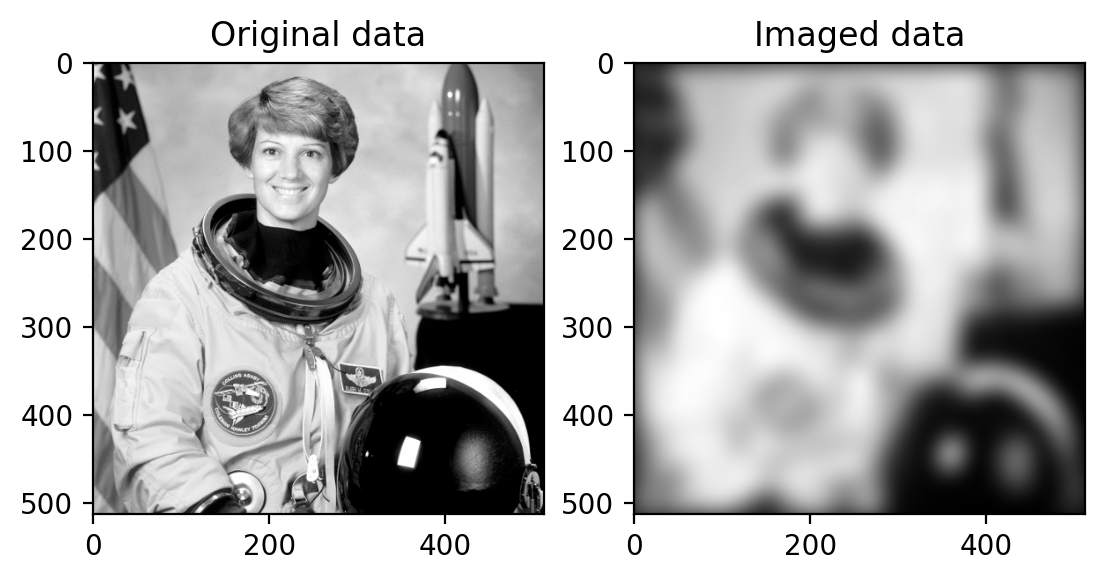

In [14]:
plt.subplot(121)
plt.title("Original data")
plt.imshow(data.squeeze(), cmap='gray')

plt.subplot(122)
plt.title("Imaged data")
plt.imshow(image.squeeze(), cmap='gray')